Test MSE: 2.490086e-06
Test Max |error|: 5.684520e-03


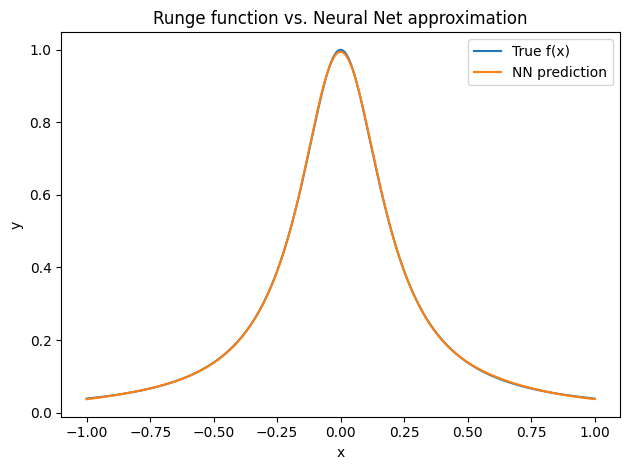

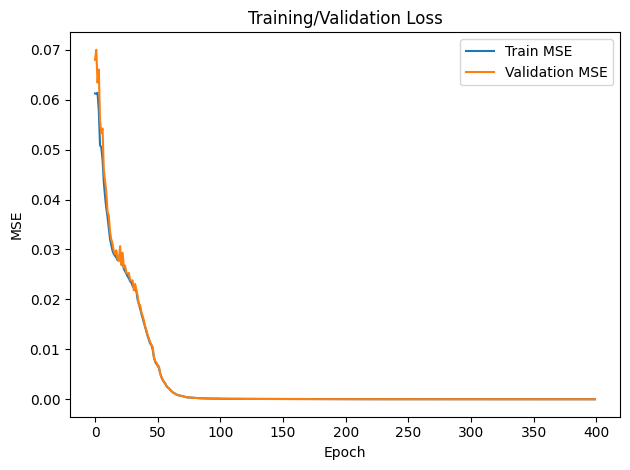

In [1]:
# Rerun quickly with fewer epochs to avoid timeout
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

def runge(x):
    return 1.0 / (1.0 + 25.0 * x**2)

n_train, n_val, n_test = 256, 256, 1000
x_train = np.random.uniform(-1.0, 1.0, size=(n_train, 1))
x_val   = np.random.uniform(-1.0, 1.0, size=(n_val, 1))
x_test  = np.linspace(-1.0, 1.0, n_test).reshape(-1, 1)

y_train = runge(x_train)
y_val   = runge(x_val)
y_test  = runge(x_test)

def to_tensor(a): return torch.from_numpy(a).float()
Xtr, Ytr = to_tensor(x_train), to_tensor(y_train)
Xva, Yva = to_tensor(x_val),   to_tensor(y_val)
Xte, Yte = to_tensor(x_test),  to_tensor(y_test)

train_ds = TensorDataset(Xtr, Ytr)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

model = MLP()
opt = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

epochs = 400
train_losses, val_losses = [], []
best_val = float("inf")
best_state = None
patience, since_best = 60, 0

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()

    model.eval()
    with torch.no_grad():
        tr_loss = loss_fn(model(Xtr), Ytr).item()
        va_loss = loss_fn(model(Xva), Yva).item()
    train_losses.append(tr_loss); val_losses.append(va_loss)

    if va_loss < best_val - 1e-7:
        best_val = va_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        since_best = 0
    else:
        since_best += 1
        if since_best >= patience:
            break

if best_state is not None:
    model.load_state_dict(best_state)

model.eval()
with torch.no_grad():
    Ypred = model(Xte).numpy()

mse = float(np.mean((Ypred - y_test)**2))
max_err = float(np.max(np.abs(Ypred - y_test)))

print(f"Test MSE: {mse:.6e}")
print(f"Test Max |error|: {max_err:.6e}")

# Plot: true function vs prediction
plt.figure()
plt.plot(x_test.ravel(), y_test.ravel(), label="True f(x)")
plt.plot(x_test.ravel(), Ypred.ravel(), label="NN prediction")
plt.title("Runge function vs. Neural Net approximation")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.tight_layout(); plt.show()

# Plot: loss curves
plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.title("Training/Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()


Test MSE: 2.316560e-02
Test Max |error|: 4.083370e-01


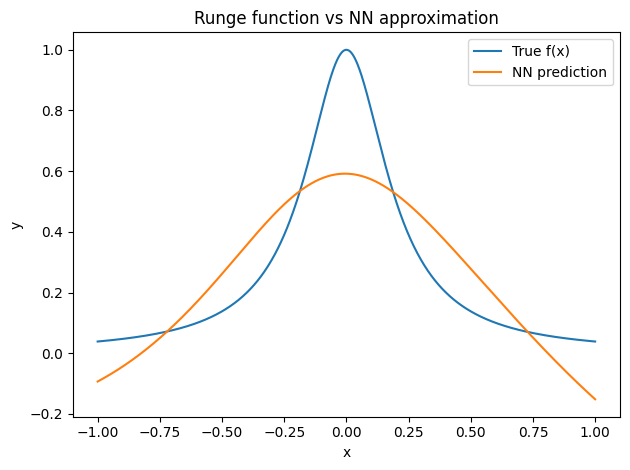

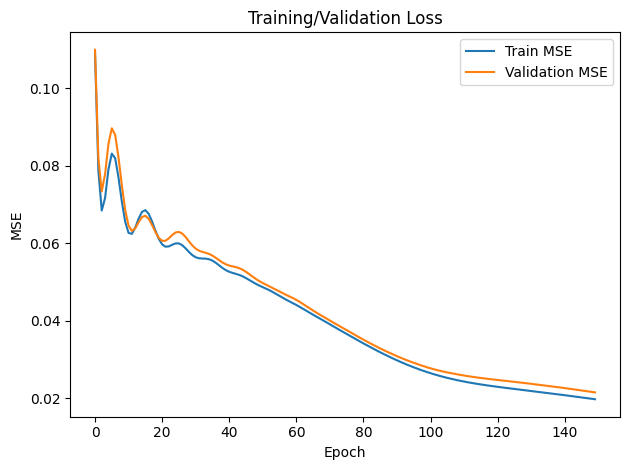

In [2]:
# Faster run: smaller net, full-batch training, fewer epochs
import numpy as np, torch
from torch import nn
import matplotlib.pyplot as plt

torch.manual_seed(0); np.random.seed(0)

def runge(x): return 1.0/(1.0+25.0*x**2)

# data
n_train, n_val, n_test = 256, 256, 1000
x_train = np.random.uniform(-1,1,(n_train,1)); y_train = runge(x_train)
x_val   = np.random.uniform(-1,1,(n_val,1));   y_val   = runge(x_val)
x_test  = np.linspace(-1,1,n_test).reshape(-1,1); y_test = runge(x_test)

Xtr = torch.tensor(x_train, dtype=torch.float32)
Ytr = torch.tensor(y_train, dtype=torch.float32)
Xva = torch.tensor(x_val, dtype=torch.float32)
Yva = torch.tensor(y_val, dtype=torch.float32)
Xte = torch.tensor(x_test, dtype=torch.float32)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.layers(x)

net = Net()
opt = torch.optim.Adam(net.parameters(), lr=2e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

epochs = 150
train_losses = []; val_losses = []
for ep in range(epochs):
    net.train()
    pred = net(Xtr)
    loss = loss_fn(pred, Ytr)
    opt.zero_grad(); loss.backward(); opt.step()

    net.eval()
    with torch.no_grad():
        train_losses.append(loss_fn(net(Xtr), Ytr).item())
        val_losses.append(loss_fn(net(Xva), Yva).item())

# evaluate
net.eval()
with torch.no_grad():
    Ypred = net(Xte).numpy()

mse = float(np.mean((Ypred - y_test)**2))
max_err = float(np.max(np.abs(Ypred - y_test)))
print(f"Test MSE: {mse:.6e}")
print(f"Test Max |error|: {max_err:.6e}")

# plot f vs prediction
plt.figure()
plt.plot(x_test.ravel(), y_test.ravel(), label="True f(x)")
plt.plot(x_test.ravel(), Ypred.ravel(), label="NN prediction")
plt.title("Runge function vs NN approximation")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.tight_layout(); plt.show()

# plot loss curves
plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.title("Training/Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()


In [3]:
# Pure NumPy neural network to approximate the Runge function quickly (no PyTorch)
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

def runge(x): 
    return 1.0/(1.0+25.0*x**2)

# data
n_train, n_val, n_test = 200, 200, 800
x_train = np.random.uniform(-1,1,(n_train,1)); y_train = runge(x_train)
x_val   = np.random.uniform(-1,1,(n_val,1));   y_val   = runge(x_val)
x_test  = np.linspace(-1,1,n_test).reshape(-1,1); y_test = runge(x_test)

# simple 1-32-32-1 tanh MLP with L2 weight decay
sizes = [1, 32, 32, 1]
W1 = np.random.randn(sizes[0], sizes[1]) * 0.5
b1 = np.zeros((1, sizes[1]))
W2 = np.random.randn
